In [1]:
import pandas as pd
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

In [ ]:
img = np.load(
    "../../100_data/test_spec.npz",
    allow_pickle=True,
)
aug = np.load(
    "../201_processing/augmented_spec.npz",
    allow_pickle=True,
)
X_tr = aug['X_train']
y_tr = aug['y_train']

img_X = img['X']
img_y = img['y']
X_tr.shape, y_tr.shape

((4794, 128, 128, 3), (4794,))

In [7]:
from sklearn.model_selection import train_test_split

_, X_te, _, y_te = train_test_split(
    img_X, img_y, test_size=0.2, random_state=42)

In [8]:
genre_names = [
    "blues",
    "classical",
    "country",
    "disco",
    "hiphop",
    "jazz",
    "metal",
    "pop",
    "reggae",
    "rock",
]

# Get y train values from strings to ints
genre_to_index = {genre: idx for idx, genre in enumerate(genre_names)}

# Convert genre names to their numeric index
y_tr = np.array([genre_to_index[genre] for genre in y_tr])
y_tr.shape

(4794,)

In [9]:
X_train = torch.from_numpy(X_tr)
# y_ohe_tr = torch.from_numpy(y_tr)
y_train = torch.from_numpy(y_tr)

X_test = torch.from_numpy(X_te)
y_ohe_te = torch.from_numpy(y_te)
y_test = torch.argmax(y_ohe_te, dim=1)


In [10]:
X_train_perm = X_train.permute(
    0, 3, 1, 2
)  # This changes the shape to [799, 3, 128, 128]

X_train_perm.shape

torch.Size([4794, 3, 128, 128])

In [11]:
from torch.utils.data import TensorDataset


# Compute the mean and std for each channel (across the training data)
# mean = X_train_perm.mean(dim=[0, 2, 3])  # Mean per channel (R, G, B)
# std = X_train_perm.std(dim=[0, 2, 3])    # Std per channel (R, G, B)

# Step 3: Normalize the images
# X_train_normalized = (X_train_perm - mean[:, None, None]) / std[:, None, None]

# Now X_train_normalized contains the normalized images, and you can create the TensorDataset
train_dataset_n = TensorDataset(X_train_perm, y_train)

X_test_perm = X_test.permute(0, 3, 1, 2)  # Reorder test data dimensions
# X_test_normalized = (X_test_perm - mean[:, None, None]) / std[:, None, None]
test_dataset = TensorDataset(X_test_perm, y_test)


In [12]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset_n, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Train FC6

In [13]:
alexnet_6 = models.alexnet(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 170MB/s]


In [14]:
alexnet_6.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [15]:
alexnet_6.classifier = torch.nn.Sequential(*list(alexnet_6.classifier.children())[:-5])
alexnet_6.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
)

In [16]:
num_ftrs = alexnet_6.classifier[1].in_features
alexnet_6.classifier[1] = torch.nn.Linear(num_ftrs, 10) # 10 music genres

# Freeze convolutional layers (optional)
for param in alexnet_6.features.parameters():
    param.requires_grad = False

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet_6 = alexnet_6.to(device)

# 1. Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet_6.classifier.parameters(), lr=0.001)  # only fine-tuning classifier

# 2. Training loop
num_epochs = 50

for epoch in range(num_epochs):
    alexnet_6.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device).type(torch.float32)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = alexnet_6(images)

        # Loss calculation
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

print("Fine-tuning complete.")


Epoch [1/50], Loss: 1.5386, Accuracy: 48.54%
Epoch [2/50], Loss: 1.1530, Accuracy: 59.89%
Epoch [3/50], Loss: 1.0526, Accuracy: 62.89%
Epoch [4/50], Loss: 0.9662, Accuracy: 67.00%
Epoch [5/50], Loss: 0.9739, Accuracy: 66.56%
Epoch [6/50], Loss: 0.8759, Accuracy: 68.84%
Epoch [7/50], Loss: 0.8612, Accuracy: 70.23%
Epoch [8/50], Loss: 0.8372, Accuracy: 71.30%
Epoch [9/50], Loss: 0.8198, Accuracy: 71.69%
Epoch [10/50], Loss: 0.8238, Accuracy: 71.01%
Epoch [11/50], Loss: 0.8014, Accuracy: 73.17%
Epoch [12/50], Loss: 0.8337, Accuracy: 71.15%
Epoch [13/50], Loss: 0.8096, Accuracy: 72.95%
Epoch [14/50], Loss: 0.7846, Accuracy: 72.63%
Epoch [15/50], Loss: 0.7897, Accuracy: 72.72%
Epoch [16/50], Loss: 0.8082, Accuracy: 72.80%
Epoch [17/50], Loss: 0.7627, Accuracy: 74.70%
Epoch [18/50], Loss: 0.7585, Accuracy: 74.47%
Epoch [19/50], Loss: 0.7457, Accuracy: 74.55%
Epoch [20/50], Loss: 0.7546, Accuracy: 74.57%
Epoch [21/50], Loss: 0.7089, Accuracy: 75.68%
Epoch [22/50], Loss: 0.7477, Accuracy: 75.0

In [18]:
# Testing
alexnet_6.eval()

with torch.no_grad():
    outputs = alexnet_6(X_test_perm.to(device).type(torch.float32))
    _, predicted6 = torch.max(outputs.data, 1)
    total = y_test.size(0)
    correct = (predicted6 == y_test.to(device)).sum()
    acc = 100 * correct / total
    print(f"Accuracy: {acc:.2f}%")

Accuracy: 57.00%


              precision    recall  f1-score   support

       blues       0.52      0.67      0.58        21
   classical       0.92      0.92      0.92        12
     country       0.48      0.54      0.51        24
       disco       0.62      0.36      0.46        22
      hiphop       0.62      0.53      0.57        15
        jazz       0.78      0.78      0.78        27
       metal       0.75      0.83      0.79        18
         pop       0.43      0.32      0.36        19
      reggae       0.39      0.55      0.45        22
        rock       0.38      0.30      0.33        20

    accuracy                           0.57       200
   macro avg       0.59      0.58      0.58       200
weighted avg       0.57      0.57      0.56       200



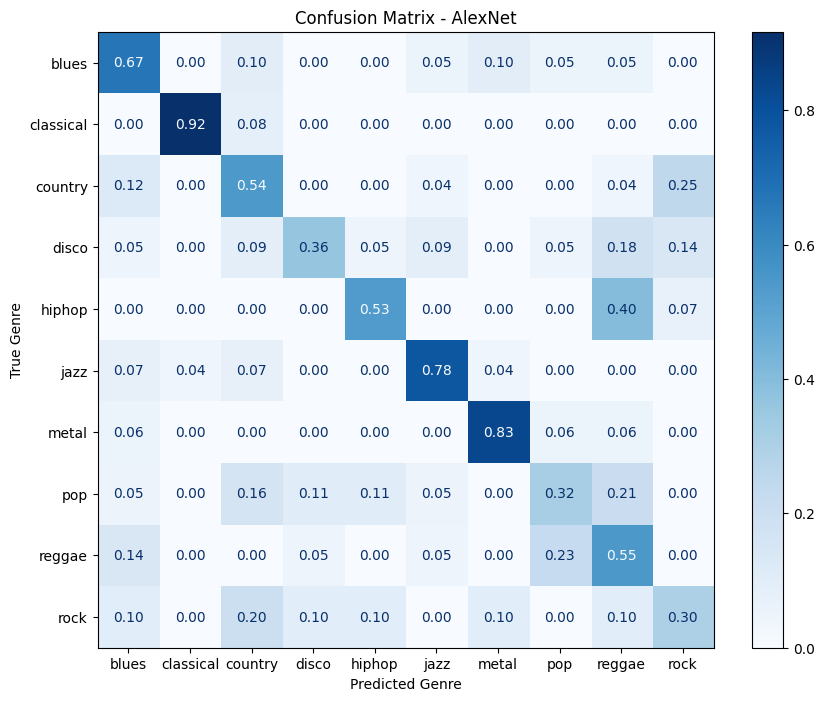

<Figure size 1000x800 with 0 Axes>

In [20]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

actual = y_test.cpu().numpy()
preds6 = predicted6.cpu().numpy()

print(classification_report(actual, preds6, target_names=genre_names))
cm  = confusion_matrix(actual, preds6, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genre_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, values_format=".2f", ax=ax)

plt.figure(figsize=(10, 8))
ax.set_xlabel("Predicted Genre")
ax.set_ylabel("True Genre")
ax.set_title("Confusion Matrix - AlexNet")
plt.tight_layout()
plt.show()

Training FC7

In [21]:
alexnet_7 = models.alexnet(pretrained=True)
alexnet_7.classifier = torch.nn.Sequential(*list(alexnet_7.classifier.children())[:-2])
alexnet_7.classifier

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
)

In [22]:
num_ftrs = alexnet_7.classifier[4].in_features
alexnet_7.classifier[4] = torch.nn.Linear(num_ftrs, 10) # 10 music genres

# Freeze convolutional layers (optional)
for param in alexnet_7.features.parameters():
    param.requires_grad = False

In [23]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet_7 = alexnet_7.to(device)

# 1. Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet_7.classifier.parameters(), lr=0.001)  # only fine-tuning classifier

# 2. Training loop
num_epochs = 50

for epoch in range(num_epochs):
    alexnet_7.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device).type(torch.float32)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = alexnet_7(images)

        # Loss calculation
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

print("Fine-tuning complete.")

Epoch [1/50], Loss: 1.9530, Accuracy: 42.18%
Epoch [2/50], Loss: 1.2980, Accuracy: 53.63%
Epoch [3/50], Loss: 1.2183, Accuracy: 56.09%
Epoch [4/50], Loss: 1.1630, Accuracy: 58.95%
Epoch [5/50], Loss: 1.1004, Accuracy: 60.72%
Epoch [6/50], Loss: 1.0681, Accuracy: 61.41%
Epoch [7/50], Loss: 1.0314, Accuracy: 63.27%
Epoch [8/50], Loss: 1.0392, Accuracy: 63.37%
Epoch [9/50], Loss: 0.9861, Accuracy: 65.58%
Epoch [10/50], Loss: 0.9775, Accuracy: 65.10%
Epoch [11/50], Loss: 0.9309, Accuracy: 66.29%
Epoch [12/50], Loss: 0.9075, Accuracy: 67.46%
Epoch [13/50], Loss: 0.8981, Accuracy: 68.59%
Epoch [14/50], Loss: 0.8793, Accuracy: 68.13%
Epoch [15/50], Loss: 0.8687, Accuracy: 68.63%
Epoch [16/50], Loss: 0.8197, Accuracy: 70.36%
Epoch [17/50], Loss: 0.8499, Accuracy: 69.38%
Epoch [18/50], Loss: 0.8565, Accuracy: 69.15%
Epoch [19/50], Loss: 0.8188, Accuracy: 70.73%
Epoch [20/50], Loss: 0.8336, Accuracy: 69.65%
Epoch [21/50], Loss: 0.7994, Accuracy: 70.80%
Epoch [22/50], Loss: 0.7906, Accuracy: 71.5

In [24]:
# Testing
alexnet_7.eval()

with torch.no_grad():
    outputs = alexnet_7(X_test_perm.to(device).type(torch.float32))
    _, predicted7 = torch.max(outputs.data, 1)
    total = y_test.size(0)
    correct = (predicted7 == y_test.to(device)).sum()
    acc = 100 * correct / total
    print(f"Accuracy: {acc:.2f}%")

Accuracy: 59.50%


              precision    recall  f1-score   support

       blues       0.62      0.71      0.67        21
   classical       1.00      0.92      0.96        12
     country       0.52      0.62      0.57        24
       disco       0.60      0.55      0.57        22
      hiphop       0.53      0.53      0.53        15
        jazz       0.92      0.81      0.86        27
       metal       0.65      0.83      0.73        18
         pop       0.54      0.37      0.44        19
      reggae       0.39      0.41      0.40        22
        rock       0.28      0.25      0.26        20

    accuracy                           0.59       200
   macro avg       0.61      0.60      0.60       200
weighted avg       0.60      0.59      0.59       200



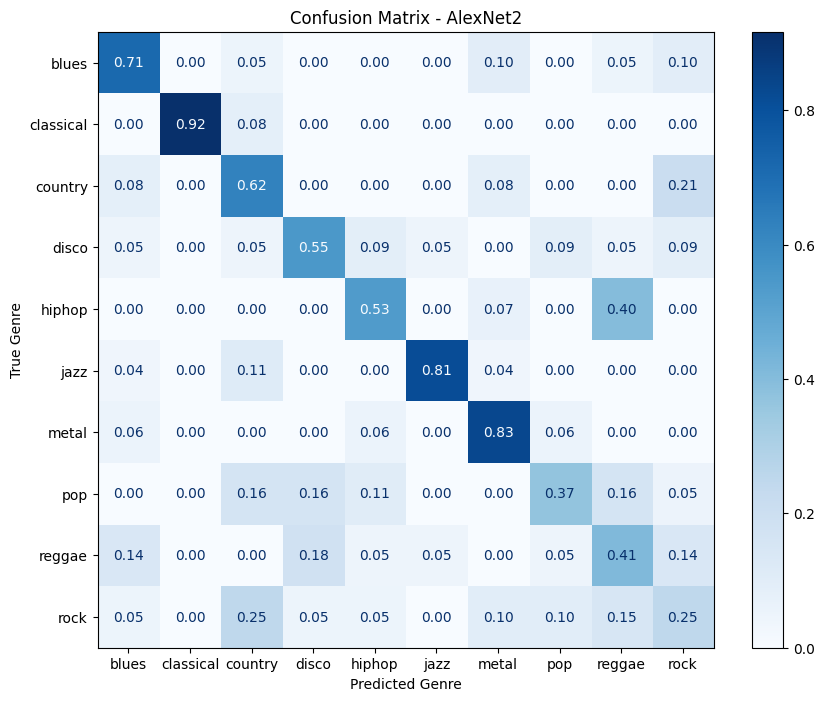

<Figure size 1000x800 with 0 Axes>

In [25]:
preds7 = predicted7.cpu().numpy()

print(classification_report(actual, preds7, target_names=genre_names))
cm  = confusion_matrix(actual, preds7, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genre_names)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, values_format=".2f", ax=ax)
plt.figure(figsize=(10, 8))
ax.set_xlabel("Predicted Genre")
ax.set_ylabel("True Genre")
ax.set_title("Confusion Matrix - AlexNet2")
plt.tight_layout()
plt.show()

Training FC8

In [26]:
# 1. Load pre-trained AlexNet
alexnet_8 = models.alexnet(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
# Replace the last fully connected layer
num_ftrs = alexnet_8.classifier[6].in_features
alexnet_8.classifier[6] = torch.nn.Linear(num_ftrs, 10) # 10 music genres

# Freeze convolutional layers (optional)
for param in alexnet_8.features.parameters():
    param.requires_grad = False


In [28]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet_8 = alexnet_8.to(device)

# 1. Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet_8.classifier.parameters(), lr=0.001)  # only fine-tuning classifier

# 2. Training loop
num_epochs = 50

for epoch in range(num_epochs):
    alexnet_8.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device).type(torch.float32)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = alexnet_8(images)

        # Loss calculation
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

print("Fine-tuning complete.")


Epoch [1/50], Loss: 1.7060, Accuracy: 39.59%
Epoch [2/50], Loss: 1.3499, Accuracy: 52.69%
Epoch [3/50], Loss: 1.2505, Accuracy: 55.19%
Epoch [4/50], Loss: 1.1928, Accuracy: 57.22%
Epoch [5/50], Loss: 1.1727, Accuracy: 58.20%
Epoch [6/50], Loss: 1.1252, Accuracy: 59.89%
Epoch [7/50], Loss: 1.1069, Accuracy: 60.78%
Epoch [8/50], Loss: 1.0670, Accuracy: 62.64%
Epoch [9/50], Loss: 1.0375, Accuracy: 62.70%
Epoch [10/50], Loss: 0.9872, Accuracy: 65.92%
Epoch [11/50], Loss: 1.0170, Accuracy: 64.27%
Epoch [12/50], Loss: 0.9951, Accuracy: 65.10%
Epoch [13/50], Loss: 0.9573, Accuracy: 65.89%
Epoch [14/50], Loss: 0.9561, Accuracy: 66.52%
Epoch [15/50], Loss: 0.9261, Accuracy: 67.38%
Epoch [16/50], Loss: 0.9061, Accuracy: 67.75%
Epoch [17/50], Loss: 0.8848, Accuracy: 69.32%
Epoch [18/50], Loss: 0.8888, Accuracy: 68.38%
Epoch [19/50], Loss: 0.8701, Accuracy: 69.04%
Epoch [20/50], Loss: 0.8848, Accuracy: 69.48%
Epoch [21/50], Loss: 0.8465, Accuracy: 70.28%
Epoch [22/50], Loss: 0.8313, Accuracy: 70.4

In [29]:
# Testing
alexnet_8.eval()

with torch.no_grad():
    outputs = alexnet_8(X_test_perm.to(device).type(torch.float32))
    _, predicted8 = torch.max(outputs.data, 1)
    total = y_test.size(0)
    correct = (predicted8 == y_test.to(device)).sum()
    acc = 100 * correct / total
    print(f"Accuracy: {acc:.2f}%")

Accuracy: 59.50%


              precision    recall  f1-score   support

       blues       0.89      0.38      0.53        21
   classical       0.92      0.92      0.92        12
     country       0.55      0.75      0.63        24
       disco       0.62      0.36      0.46        22
      hiphop       0.50      0.47      0.48        15
        jazz       0.88      0.78      0.82        27
       metal       0.82      0.78      0.80        18
         pop       0.37      0.37      0.37        19
      reggae       0.47      0.64      0.54        22
        rock       0.38      0.55      0.45        20

    accuracy                           0.59       200
   macro avg       0.64      0.60      0.60       200
weighted avg       0.64      0.59      0.60       200



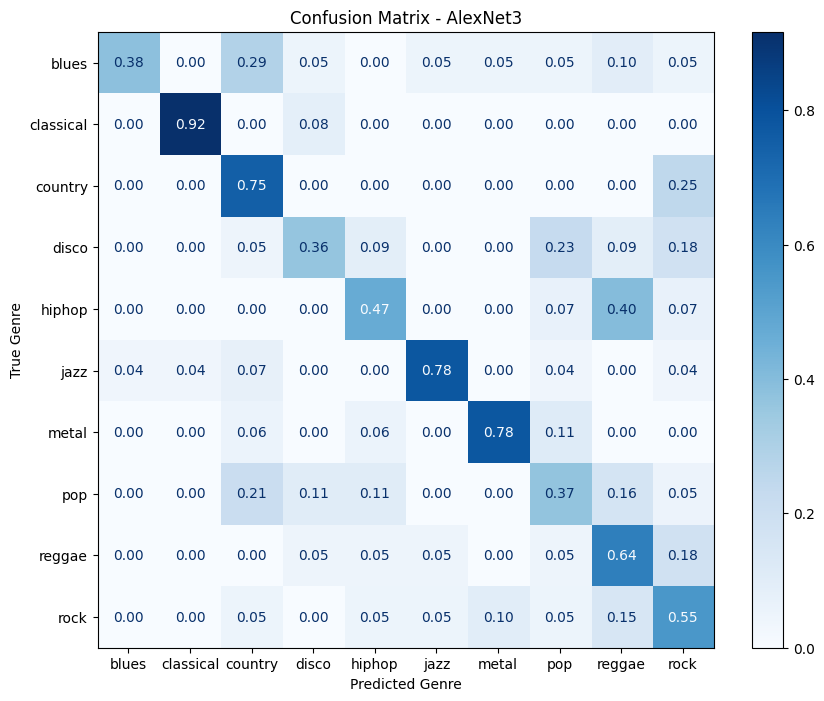

<Figure size 1000x800 with 0 Axes>

In [30]:
preds8 = predicted8.cpu().numpy()

print(classification_report(actual, preds8, target_names=genre_names))
cm  = confusion_matrix(actual, preds8, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genre_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, values_format=".2f", ax=ax)

plt.figure(figsize=(10, 8))
ax.set_xlabel("Predicted Genre")
ax.set_ylabel("True Genre")
ax.set_title("Confusion Matrix - AlexNet3")
plt.tight_layout()
plt.show()

Nothing Frozen - FC8 (Horrible until I adjusted lr to 1e-5!)

In [31]:
alexnet = models.alexnet(pretrained=True)

# Replace the last fully connected layer
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = torch.nn.Linear(num_ftrs, 10) # 10 music genres

for param in alexnet.parameters():
    param.requires_grad = True

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet = alexnet.to(device)

# 1. Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.00001)  # fine-tune all

# 2. Training loop
num_epochs = 50

for epoch in range(num_epochs):
    alexnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device).type(torch.float32)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = alexnet(images)

        # Loss calculation
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

print("Fine-tuning complete.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Loss: 1.8389, Accuracy: 34.40%
Epoch [2/50], Loss: 1.2880, Accuracy: 54.55%
Epoch [3/50], Loss: 1.0743, Accuracy: 62.35%
Epoch [4/50], Loss: 0.9289, Accuracy: 67.98%
Epoch [5/50], Loss: 0.8158, Accuracy: 71.67%
Epoch [6/50], Loss: 0.6991, Accuracy: 75.59%
Epoch [7/50], Loss: 0.6120, Accuracy: 78.97%
Epoch [8/50], Loss: 0.5512, Accuracy: 80.87%
Epoch [9/50], Loss: 0.4727, Accuracy: 83.31%
Epoch [10/50], Loss: 0.4133, Accuracy: 86.02%
Epoch [11/50], Loss: 0.3564, Accuracy: 87.90%
Epoch [12/50], Loss: 0.3112, Accuracy: 89.40%
Epoch [13/50], Loss: 0.2590, Accuracy: 90.80%
Epoch [14/50], Loss: 0.2142, Accuracy: 93.07%
Epoch [15/50], Loss: 0.1955, Accuracy: 93.43%
Epoch [16/50], Loss: 0.1745, Accuracy: 94.33%
Epoch [17/50], Loss: 0.1422, Accuracy: 95.93%
Epoch [18/50], Loss: 0.1271, Accuracy: 96.10%
Epoch [19/50], Loss: 0.0992, Accuracy: 97.35%
Epoch [20/50], Loss: 0.0921, Accuracy: 97.29%
Epoch [21/50], Loss: 0.0819, Accuracy: 97.77%
Epoch [22/50], Loss: 0.0659, Accuracy: 98.4

In [32]:
# Testing
alexnet.eval()

with torch.no_grad():
    outputs = alexnet(X_test_perm.to(device).type(torch.float32))
    _, predicted = torch.max(outputs.data, 1)
    total = y_test.size(0)
    correct = (predicted == y_test.to(device)).sum()
    acc = 100 * correct / total
    print(f"Accuracy: {acc:.2f}%")

Accuracy: 73.50%


              precision    recall  f1-score   support

       blues       0.68      0.81      0.74        21
   classical       1.00      1.00      1.00        12
     country       0.66      0.88      0.75        24
       disco       0.65      0.59      0.62        22
      hiphop       0.75      0.80      0.77        15
        jazz       0.90      1.00      0.95        27
       metal       0.80      0.89      0.84        18
         pop       0.69      0.47      0.56        19
      reggae       0.63      0.55      0.59        22
        rock       0.62      0.40      0.48        20

    accuracy                           0.73       200
   macro avg       0.74      0.74      0.73       200
weighted avg       0.73      0.73      0.72       200



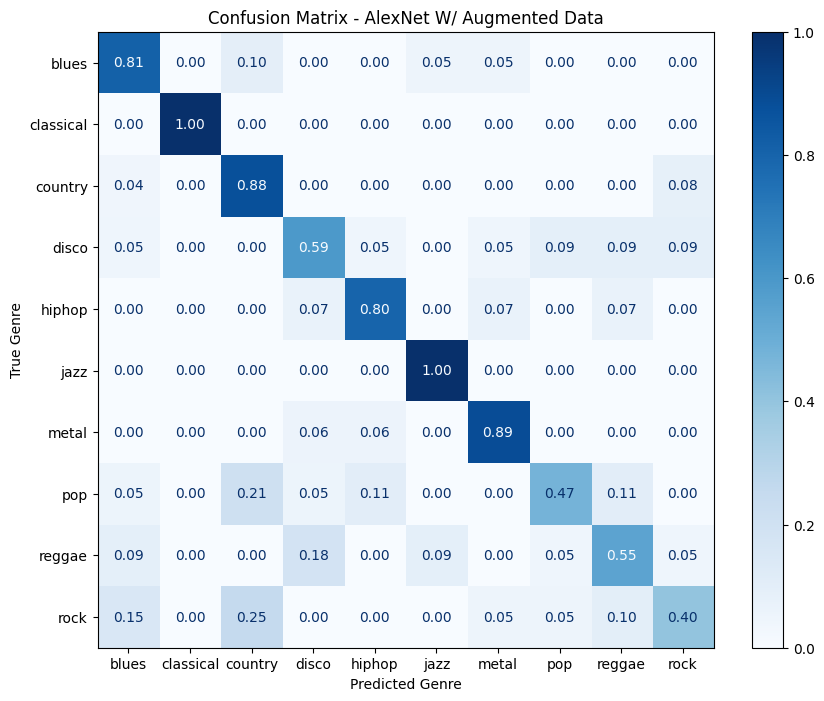

<Figure size 1000x800 with 0 Axes>

In [34]:
preds = predicted.cpu().numpy()

print(classification_report(actual, preds, target_names=genre_names))
cm  = confusion_matrix(actual, preds, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genre_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, values_format=".2f", ax=ax)

plt.figure(figsize=(10, 8))
ax.set_xlabel("Predicted Genre")
ax.set_ylabel("True Genre")
ax.set_title("Confusion Matrix - AlexNet W/ Augmented Data")
plt.tight_layout()
plt.show()

Old Stuff

In [ ]:
from torch.utils.data import TensorDataset, Subset, random_split

dataset = TensorDataset(X_tensor, y_tensor)

# Step 2: Shuffle the dataset indices
num_samples = len(dataset)
shuffled_indices = torch.randperm(num_samples)

# Step 3: Split the shuffled indices
train_size = int(0.8 * num_samples)
train_indices = shuffled_indices[:train_size]
test_indices = shuffled_indices[train_size:]

# Step 4: Create training and testing datasets directly
X_train = X_tensor[train_indices]
y_train = y_tensor[train_indices]
X_test = X_tensor[test_indices]
y_test = y_tensor[test_indices]

#train_dataset = TensorDataset(X_train, y_train)
#test_dataset = TensorDataset(X_test, y_test)